# Correlation(상관관계)

## 정의
- 두 변수간에 서로 얼마나 함께 변하는지 정도를 나타내는 통계 개념
- 값의 범위는 : -1 ~ +1
    - +1: 완벽한 양의 상관관계 -> x가 증가하면 y도 비례해서 증가 : 키 - 몸무게
    - 0: 상관없음 : 키와 수함점수
    - -1: 완벽한 음의 상관관계 -> x가 증가하면 y가 비례해서 감소 : 운동량 - 체지방률

## 상관 계수 ($r$)
두 변수간의 관계가 얼마나 강한지 측정하는 법 (대표적)
- 피어슨 (Pearson) : 가장 많이 쓰임. 연속 변수 선형 관계 측정
- 스피어맨 (Spearman) : 순위(랭크) 기반, 비 선형 관계, 이상치에 강함
- 켄달 (Kendall) : 순위 일관성 기반, 표본이 적을 때 안정적


In [ ]:
%pip install -q kagglehub[pandas-datasets]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('./OnlineRetail.csv', encoding='ISO-8859-1')

In [ ]:
from da_utils import profile, outliers, patterns

# 데이터 프로파일링
profile.get_data_profile(df)

In [ ]:
# 결측치 모니터링 함수
patterns.analyze_missing_patterns(df)

In [ ]:
# 이상치 탐지 함수 (결측치 처리후 실행 필요)
outliers.outlier_detection(df.fillna(0), 0.999, iso_cont='auto', final_threshold=2)

In [ ]:
print('전체거래', len(df))
print('고유 InvoiceNo', df['InvoiceNo'].nunique())
print('고유 고객수', df['CustomerID'].nunique())

In [ ]:
# 데이터 전처리
df_clean = df.copy()

# CustomerID 결측값 제거 (고객 단위 분석을 위해 필수)
missing_customers = df_clean['CustomerID'].isnull().sum()
print(f'CustomerID 결측값 제거: {missing_customers}건')
df_clean = df_clean.dropna(subset=['CustomerID'])

# 취소 거래 분리 (InvoiceNo가 'C'로 시작)
cancel_mask = df_clean['InvoiceNo'].astype('str').str.startswith('C')
# 취소거래, 정상거래 분리
df_cancel = df_clean[cancel_mask]
df_clean = df_clean[~cancel_mask]
print(f'취소거래 분리: {len(df_cancel)}건')
print(f'정상 거래: {len(df_clean)}건')

# 파생 변수 생성 (상관 관계 분석)
# TotalAmount, InvoiceDate(DateTime), Year, Month, DayOfWeek(숫자), Hour, Dayname(글자), customerID(Str)
df_clean['TotalAmount'] =  df['UnitPrice'] * df['Quantity']
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_of_week
df_clean['Dayname'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int).astype(str)


print('\n=== 이상값 확인 ===')
print(f'음수 수량: {(df_clean['Quantity'] < 0).sum()}')
print(f'음수 단가: {(df_clean['UnitPrice'] < 0).sum()}')
print(f'0 단가: {(df_clean['UnitPrice'] == 0).sum()}')

# 양수 수량 & 양수 단가 데이터만 살리기
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

df_clean.info()

In [ ]:
print('=== 고객별 구매 패턴 특성 DF 생성 ===')

customer_stats = df_clean.groupby('CustomerID').agg({
    'InvoiceNo':  'nunique',  # 구매 횟수(Frequency)
    'Quantity': ['sum', 'mean'],  # 총구매량, 평균구매량
    'UnitPrice': 'mean',  # 평균 단가
    'TotalAmount': ['sum', 'mean'],  # 총 구매액(Monetary), 평균 구매액
    'StockCode': 'nunique',  # 구매한 상품 종류 수
    'InvoiceDate': ['min', 'max'],  # 첫 구매일, 마지막 구매일
}).round(2)

# 컬럼명 정리 (구매횟수==F, 총구매액==M)
customer_stats.columns = ['Frequency', '총구매량', '평균구매량', '평균단가', 
                        'Monetary', '평균구매액', '상품종류수', '첫구매일', '마지막구매일']

# 구매 기간 및 주기 계산 (추가하기)
customer_stats['구매기간일수'] = (customer_stats['마지막구매일'] - customer_stats['첫구매일']).dt.days + 1
customer_stats['구매주기'] = customer_stats['구매기간일수'] / customer_stats['Frequency']

# RFM 분석 변수
analysis_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
customer_stats['Recency'] = (analysis_date - customer_stats['마지막구매일']).dt.days


# RFM점수 (모두 5등급) (.qcut으로 5등분)
customer_stats['R_score'] = pd.qcut(customer_stats['Recency'], 5, labels=[5,4,3,2,1])
customer_stats['F_score'] = pd.qcut(customer_stats['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
customer_stats['M_score'] = pd.qcut(customer_stats['Monetary'], 5, labels=[1,2,3,4,5])
customer_stats['RFM_score'] = (customer_stats['R_score'].astype(str) + \
                                customer_stats['F_score'].astype(str) + \
                                customer_stats['M_score'].astype(str))
# 추가정보
customer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['Frequency']
customer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['Frequency']

# 가격 민감도 - 단가가 상대적으로 일관되게 유지되는가?
# CV = Coefficient of Variation (표준편차 / 평균) => 높으면, 다양한 가격대로 산다 / 낮으면, 특정 가격대에 고정적 구매
price_cv = df_clean.groupby('CustomerID')['UnitPrice'].agg(['mean', 'std'])
price_cv['가격변동성'] = (price_cv['std'] / price_cv['mean']).fillna(0)

customer_stats = customer_stats.merge(
    price_cv[['가격변동성']], # 두 DF 다 컬럼이 아닌 인덱스가 CustomerID
    left_index=True,   # customer_stats의 인덱스 기준으로 병합
    right_index=True   # price_cv의 인덱스 기준으로 병합
)

customer_stats

In [ ]:
print('=== 기본 상관관계 분석 ===')

# 수치형 상관관게 분석용
numeric_cols =  ['Frequency', '총구매량', '평균구매량', '평균단가', 'Monetary', 
                 '평균구매액', '상품종류수', '구매기간일수', '구매주기', 'Recency', 
                 '평균장바구니크기', '거래당상품종류', '가격변동성']

correlation_data = customer_stats[numeric_cols]
correlation_data.head(3)



In [ ]:
# 피어슨 상관관계

pearson_corr = correlation_data.corr(method='pearson')
spearman_corr = correlation_data.corr(method='spearman')
display(pearson_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_corr,
    annot=True,        # 셀에 값 표시
    fmt=".2f",         # 소수점 2자리
    cmap='coolwarm',   # 색상 팔레트
    linewidths=0.5,    # 셀 경계선
    cbar_kws={"shrink": 0.8}  # 색상바 크기 조절
)

plt.title('피어슨 상관계수 히트맵', fontsize=10)


plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr,
    annot=True,        # 셀에 값 표시
    fmt=".2f",         # 소수점 2자리
    cmap='coolwarm',   # 색상 팔레트
    linewidths=0.5,    # 셀 경계선
    cbar_kws={"shrink": 0.8}  # 색상바 크기 조절
)

plt.title('스피어맨 상관계수 히트맵', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# 피어슨 상관관계 - 키 <-> 몸무게 / 온도 <-> 전력 같이 실제 값이 비례하는 경우
pearson_corr = correlation_data.corr(method='pearson')
# 스피어만 상관관계 - 시험순위 <-> 대회순위 /  만족도 <-> 재구매의사
spearman_corr = correlation_data.corr(method='spearman')

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

# 피어슨 상관관계 히트맵    
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a1, cbar_kws={'label': 'Pearson 상관계수'})
a1.set_title('피어슨 상관관계 (선형 관계)', fontsize=14)

# sns.heatmap(
#     pearson_corr,
#     annot=True,        # 셀에 값 표시
#     fmt=".2f",         # 소수점 2자리
#     cmap='coolwarm',   # 색상 팔레트
#     linewidths=0.5,    # 셀 경계선
#     cbar_kws={"shrink": 0.8}  # 색상바 크기 조절
# )

# 스피어만 상관관계 히트맵
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a2, cbar_kws={'label': 'Spearman 상관계수'})
a2.set_title('스피어만 상관관계 (순위 기반)', fontsize=14)

corr_diff = abs(spearman_corr - pearson_corr) # 진한 색일수록 선형관계가 아님.
sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='Reds',
             square=True, ax=a3, cbar_kws={'label': '|차이|'})
a3.set_title('피어슨 vs 스피어만 차이(비선형성지표)')

# 강한 상관관계 (|r| > 0.5) 네트워크
strong_corr = pearson_corr.copy()
strong_corr[abs(strong_corr) < 0.5] = 0

np.fill_diagonal(strong_corr.values, 0)

sns.heatmap(strong_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a4, cbar_kws={'label': '강한 상관관계'})
a4.set_title('강한 상관관계 (|r| > 0.5)', fontsize=14)
    
plt.tight_layout()
plt.show()

# 주요 발견사항 요약
print('\n=== 주요 상관관계 발견사항 ===')
# 아래 히트맵에서 위쪽 삼각형만 보겠다
upper_triangle = np.triu(pearson_corr, k=1)
# 가장 큰 값이 있는 인덱스
strong_positive = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
# 가장 강한 양의 상관관계
max_corr = pearson_corr.iloc[strong_positive]
max_corr

print(f'가장 강한 양의 상관관계: {max_corr:.3f}')
print(f'  {pearson_corr.index[strong_positive[0]]} <-> {pearson_corr.index[strong_positive[1]]}')

strong_negative = np.unravel_index(np.argmin(upper_triangle), upper_triangle.shape)
min_corr = pearson_corr.iloc[strong_negative]

print(f'가장 강한 음의 상관관계: {min_corr:.3f}')
print(f'  {pearson_corr.index[strong_negative[0]]} <-> {pearson_corr.index[strong_negative[1]]}')


In [ ]:
print('매출 증대 핵심 요인')
monetary_corr = pearson_corr['Monetary'].abs().sort_values(ascending=False)

for factor, corr in monetary_corr.head(6).items():
    if factor != 'Monetary':
        print(f' {factor}: {corr:.3f}')


print('고객 충성도 관련 요인')
Frequency_corr = pearson_corr['Frequency'].abs().sort_values(ascending=False)

for factor, corr in Frequency_corr.head(6).items():
    if factor != 'Frequency':
        print(f' {factor}: {corr:.3f}')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# 그래프 2차원 리스트 -> 1차원으로 평탄화
axes = axes.ravel()
relationships = [
    ('평균단가', 'Monetary', '평균단가 vs 총구매액'),
    ('Frequency', '상품종류수', '구매횟수 vs 상품종류수'),
    ('구매주기', 'Recency', '구매주기 vs 최근성'), 
    ('평균장바구니크기', 'Monetary', '장바구니크기 vs 총구매액'),
    ('가격변동성', '상품종류수', '가격변동성 vs 상품종류수'),
    ('거래당상품종류', '평균구매액', '거래당상품종류 vs 평균구매액')
]

for idx, (x, y, title) in enumerate(relationships):
    # 산점도
    axes[idx].scatter(customer_stats[x], customer_stats[y], alpha=0.6, s=10)
    # 선형 회귀선(트렌드라인)
    z = np.polyfit(customer_stats[x], customer_stats[y], 1) # x, y 값에 대한 집합을 주고, 몇차원으로 할지 알려주면 함수를 뽑아냄(1 -> 1차함수로 뽑아라)
    # 기울기, y절편
    print(z[0], z[1])
    # 데이터별 1차함수
    p = np.poly1d(z)
    axes[idx].plot(customer_stats[x], p(customer_stats[x]), 'r--', alpha=0.8, linewidth=2)

    # 둘다 높음 -> 강한 선형 + 순위
    # P > S -> 값은 비례하지만, 순위는 뒤섞임
    # P < S -> 순위는 일정하지만 비선형관계
    # 둘다 낮음 -> 관계 거의 없음
    pearson_r = customer_stats[x].corr(customer_stats[y], method='pearson')
    spearman_r = customer_stats[x].corr(customer_stats[y], method='spearman')

    axes[idx].set_xlabel(x)
    axes[idx].set_ylabel(y)
    axes[idx].set_title(f'{title}\nP:{pearson_r:.3f}, S:{spearman_r:.3f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 고급 상관관계 측정
print('=== 고급 상관관계 측정 ===')

key_vars = ['Monetary', 'Frequency', 'Recency', '평균단가', '상품종류수', '평균장바구니크기']
analysis_data = customer_stats[key_vars].copy()

kendall_results = {}

'''
켄달 타우 vs 스피어만
켄달 타우 : 데이터 개수가 적거나 순위 정보만 확실한 경우, 데이터에 이상치가 있거나 동점자가 많은 경우
스피어만 : 연속형 데이터지만, 선형이 아닐 때, 이상치가 없고, 동점자가 적은 경우
'''
from scipy.stats import kendalltau

# 켄달 타우 상관계수 (순위기반 - 이상값에 강함)
print('1. 켄달 타우 상관계수 분석')
for idx, var1 in enumerate(key_vars):
    for var2 in key_vars[idx+1:]:
        tau, p_value = kendalltau(analysis_data[var1], analysis_data[var2])
        # 켄달 타우 결과 확인(유의미한 관계만 -> p_value < 0.05)
        if p_value < 0.05 and abs(tau) > 0.1:
            kendall_results[f'{var1} vs {var2}'] = {'tau': tau, 'p_value': p_value}

for rel, stats in kendall_results.items():
    print(f' {rel} = {stats['tau']:.3f} (p={stats['p_value']:.3f})')



In [ ]:
# 상호 정보량 (Mutual Information) 기반 분석
# 선형, 비선형 구분없이 변수간 정보량 공유 정도를 측정
# MI = 0 -> 전혀 관련 없음
# MI >= 1 -> 꽤 관련 있음
# MI 꽤 많이 큼 -> 변수 X는 변수 Y 예측에 유용하다

# 켄달 타우 -> '방향'과 '순위'의 일관성
# MI 점수 -> '관계'가 있긴한데, +-몰라, 그냥 둘이 강하게 연결 되어있는거냐

from sklearn.feature_selection import mutual_info_regression
print('2. 상호정보량 기반 연관성 (Monetary 기준)')
# Monetary를 타겟으로한 상호 정보량 계산 -> 독립변수인지 체크 가능함
target = analysis_data['Monetary']
features = analysis_data.drop('Monetary', axis=1)
mi_scores = mutual_info_regression(features, target, random_state=42)
mi_results = pd.DataFrame({
    'Feature': features.columns,
    'MI_Score': mi_scores,
}).sort_values('MI_Score', ascending=False)

for _, row in mi_results.iterrows():
    print(f' {row['Feature']}: {row['MI_Score']:.3f}')

display(mi_results)

In [92]:
# 3. 조건부 상관관계 분석 (고객 세그먼트별) - VIP, 일반, 신규
customer_stats['Segment'] = 'Regular'

vip_mask = ((customer_stats['R_score'].astype(int) >= 4) &
            (customer_stats['F_score'].astype(int) >= 4) &
            (customer_stats['M_score'].astype(int) >= 4) 
        )

customer_stats.loc[vip_mask, 'Segment'] = 'VIP'
new_mask = customer_stats['Frequency'] == 1
customer_stats.loc[new_mask, 'Segment'] = 'New'

segments = ['VIP', 'Regular', 'New']
segment_corrs = {}

for seg in segments:
    seg_data = customer_stats[customer_stats['Segment'] == seg]
    if len(seg_data) > 10:
        # 세그먼트 별로 F <-> M
        corr = seg_data['Frequency'].corr(seg_data['Monetary'])
        segment_corrs[seg] = {
            'corr': corr,
            'size': len(seg_data)
        }
        print(f'  {seg} 고객: M - F = {corr:.3f}, (n={len(seg_data)})')
    


  VIP 고객: M - F = 0.543, (n=962)
  Regular 고객: M - F = 0.332, (n=1883)
  New 고객: M - F = nan, (n=1493)


U자형 관계 탐지
   가격변동성 상위 10% 고객 특성:
   - 평균 상품종류수: 76.8개
   - 평균 총구매액: 3,897원
   - 평균 구매횟수: 5.6회


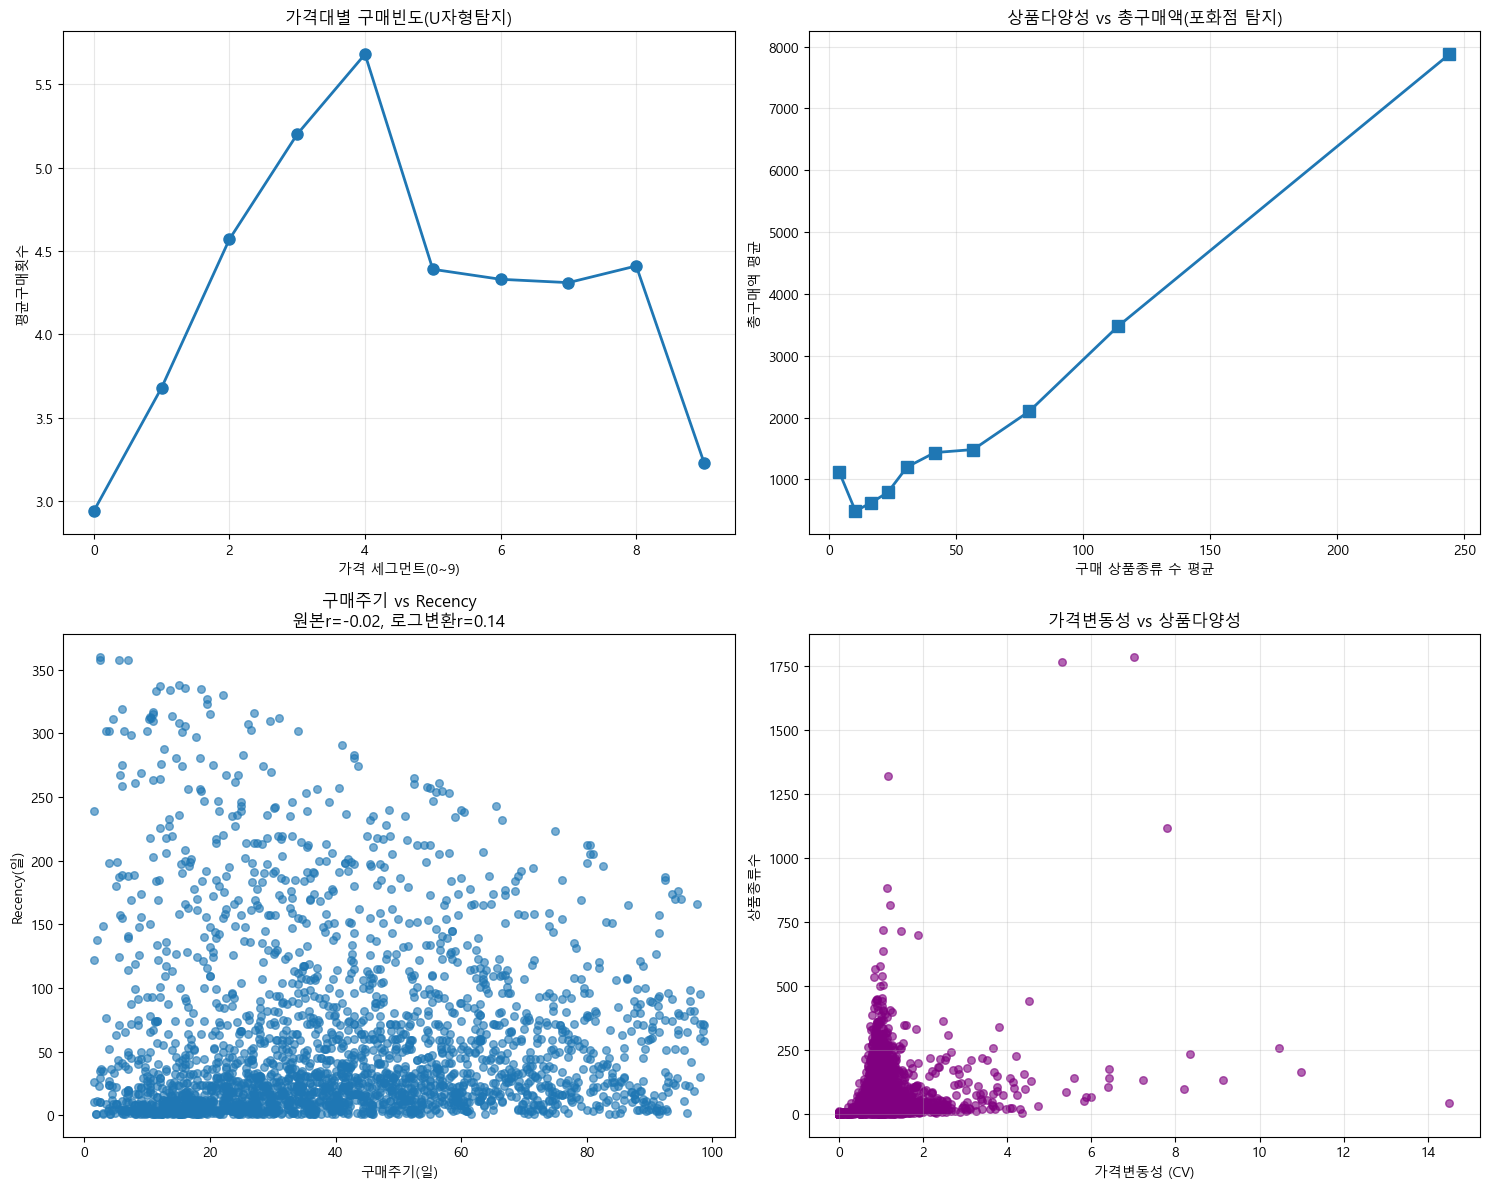

In [93]:
# 비선형 패턴 심화

print('U자형 관계 탐지')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
a1, a2, a3, a4 = axes.ravel()

# 평균 단가 구간별 구매횟수 분석
customer_stats['Price_Segment'] = pd.qcut(customer_stats['평균단가'], q=10, labels=False, duplicates='drop')

price_freq_analysis = customer_stats.groupby('Price_Segment').agg({
    'Frequency': ['mean', 'count'],
    '평균단가': 'mean',
    'Monetary': 'mean'
}).round(2)

price_freq_analysis.columns = ['평균구매횟수', '고객수', '평균단가', '평균총구매액']

a1.plot(price_freq_analysis.index, price_freq_analysis['평균구매횟수'], marker='o', linewidth=2, markersize=8)
a1.set_xlabel('가격 세그먼트(0~9)')
a1.set_ylabel('평균구매횟수')
a1.set_title('가격대별 구매빈도(U자형탐지)')
a1.grid(True, alpha=0.3)

# 구매 상품 다양성 <-> 총구매액
customer_stats['Variety_Segment'] = pd.qcut(customer_stats['상품종류수'], q=10, labels=False, duplicates='drop')

variety_analysis = customer_stats.groupby('Variety_Segment').agg({
    'Monetary': 'mean',
    '평균구매액': 'mean',
    '상품종류수': 'mean',
}).round(2)

a2.plot(variety_analysis['상품종류수'], variety_analysis['Monetary'], marker='s', linewidth=2, markersize=8)
a2.set_xlabel('구매 상품종류 수 평균')
a2.set_ylabel('총구매액 평균')
a2.set_title('상품다양성 vs 총구매액(포화점 탐지)')
a2.grid(True, alpha=0.3)

# 3. 구매주기와 Recency의 관계 (지수적 관계 확인용)
# 정상적인 구매
valid_cycle = customer_stats[customer_stats['구매주기'] < customer_stats['구매주기'].quantile(0.95)]
valid_cycle = valid_cycle[valid_cycle['구매주기'] > 1]

a3.scatter(valid_cycle['구매주기'], valid_cycle['Recency'], alpha=0.6, s=30)

a3.set_xlabel('구매주기(일)')
a3.set_ylabel('Recency(일)')

# 로그 변환 선형화
log_cycle = pd.Series(np.log1p(valid_cycle['구매주기']))
log_recency = pd.Series(np.log1p(valid_cycle['Recency']))

original_corr = valid_cycle['구매주기'].corr(valid_cycle['Recency'])
log_corr = log_cycle.corr(log_recency)
a3.set_title(f'구매주기 vs Recency\n원본r={original_corr:.2f}, 로그변환r={log_corr:.2f}')


# 가격변동성과 상품종류수 관계
a4.scatter(customer_stats['가격변동성'], customer_stats['상품종류수'], 
                    alpha=0.6, s=30, color='purple')

# 가격변동성이 높은 고객들의 특성
high_variation = customer_stats['가격변동성'] > customer_stats['가격변동성'].quantile(0.9)

print(f"   가격변동성 상위 10% 고객 특성:")
print(f"   - 평균 상품종류수: {customer_stats[high_variation]['상품종류수'].mean():.1f}개")
print(f"   - 평균 총구매액: {customer_stats[high_variation]['Monetary'].mean():,.0f}원")
print(f"   - 평균 구매횟수: {customer_stats[high_variation]['Frequency'].mean():.1f}회")

a4.set_xlabel('가격변동성 (CV)')
a4.set_ylabel('상품종류수')
a4.set_title('가격변동성 vs 상품다양성')
a4.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [ ]:
df_clean['Country'].nunique()

In [ ]:
print('=== 범주형 변수 연관성 분석 ===')

print('1. 국가별 구매 패턴 분석')
# 구매 횟수 많은 상위 10개국
country_counts = df_clean['Country'].value_counts().head(10)
major_countries = country_counts.index.to_list()
df_major = df_clean[df_clean['Country'].isin(major_countries)].copy()

# 국가별 집계 분석
country_analysis = df_major.groupby('Country').agg({
    'TotalAmount': ['sum', 'mean', 'count'],
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique'
}).round(2)

country_analysis.columns = ['총매출', '평균거래액', '거래수', '평균수량', '평균단가', '고객수']
country_analysis['고객당매출'] = (country_analysis['총매출'] / country_analysis['고객수']).round(2)

print('주요 국가별 구매 지표')
display(country_analysis.sort_values('총매출', ascending=False))

# 2. 시간대별 구매 패턴 분석
print('\n 시간대별 구매 패턴')
hourly_analysis = df_clean.groupby('Hour').agg({
    'TotalAmount': ['sum', 'mean', 'count'],
    'CustomerID': 'nunique',
}).round(2)

hourly_analysis.columns = ['총매출', '평균거래액', '거래수', '고객수']
peak_hours = hourly_analysis.nlargest(3, '거래수')
print('거래량 상위 3개 시간대')
for hour in peak_hours.index:
    print(f'  {hour}시: {peak_hours.loc[hour, '거래수']}건')


# 3. 요일별 구매 패턴
print('\n 요일별 구매 패턴')
daily_analysis = df_clean.groupby('Dayname').agg({
    'TotalAmount': ['sum', 'mean'],
    'Quantity': 'sum',
    'CustomerID': 'nunique',
}).round(2)

daily_analysis.columns = ['총매출', '평균거래액', '총수량', '고객수']
# 요일 순서 정렬 (인덱스 재정렬)

# nlargest 총매출로 가장 많이 팔리는 요일 3개 분석
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
daily_analysis = daily_analysis.reindex(day_order)
peak_days = daily_analysis.nlargest(3, '총매출')

for day in peak_days.index:
    print(f'  {day}: {peak_days.loc[day, '총매출']}원')
print('요일별 매출 현황')
display(daily_analysis)

=== 카이제곱 검정 & Cramer's V 분석 ===


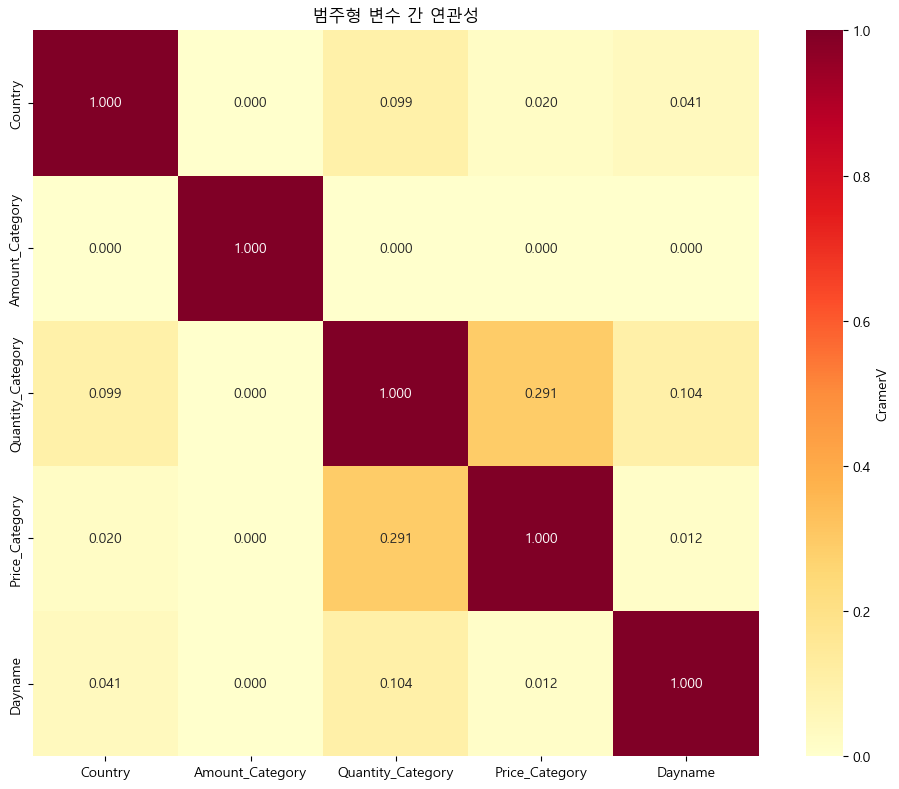

   Quantity_Category ↔ Price_Category: 0.291

가장 강한 연관성 상세 분석: Quantity_Category vs Price_Category
교차표 (행 기준 백분율):


Price_Category,저가,중가,고가
Quantity_Category,,,
소,24.0,34.2,41.8
중,23.8,45.4,30.8
대,61.5,31.6,6.9



카이제곱 검정 결과:
   카이제곱 통계량: 64584.349
   p-value: 0.000000
   자유도: 4
   결론: 유의한 연관성 있음 (α=0.05)


In [91]:
from scipy.stats import chi2_contingency

# 카이제곱 검정과 Cramer's V 분석
# 카이제곱 -> 범주형 데이터간의 연관 O / X
# Cramer's V -> 범주형 데이터간 얼마나 강하게 연관되어 있는지 설명

print('=== 카이제곱 검정 & Cramer\'s V 분석 ===')

df_analysis = df_major.copy()

# 범주형 변수로 변환

# 거래액 구간화
df_analysis['Amount_Cateogry'] = pd.qcut(df_analysis['TotalAmount'], q=4, labels=['저액', '중저액', '중고액', '고액'])
# 수량 구간화
df_analysis['Quantity_Category'] = pd.qcut(df_analysis['Quantity'], q=3, labels=['소', '중', '대'])
# 단가 구간화
df_analysis['Price_Category'] = pd.qcut(df_analysis['UnitPrice'], q=3, labels=['저가', '중가', '고가'])

# 크레머-v 계산기
def cramers_v(x, y):
    """Cramér's V 계산"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 카테고리형 변수
categorical_vars = ['Country', 'Amount_Category', 'Quantity_Category', 'Price_Category', 'Dayname']

# 분석효율을 위해 5개만 선택
top_5_countries = df_analysis['Country'].value_counts().head(5).index
df_analysis = df_analysis[df_analysis['Country'].isin(top_5_countries)]

# Cramér's V 매트릭스 계산
cramers_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 == var2:
            cramers_matrix.loc[var1, var2] = 1.0
        else:
            try:
                cramers_matrix.loc[var1, var2] = cramers_v(df_analysis[var1], df_analysis[var2])
            except:
                cramers_matrix.loc[var1, var2] = 0.0

cramers_matrix = cramers_matrix.astype(float)

# Cramer 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, fmt='.3f', cmap='YlOrRd', square=True, cbar_kws={'label': 'CramerV'})
plt.title('범주형 변수 간 연관성')
plt.tight_layout()
plt.show()

upper_triangle = np.triu(cramers_matrix.values, k=1)
strong_associations = []

strong_associations = []
for i in range(len(categorical_vars)):
    for j in range(i+1, len(categorical_vars)):
        if upper_triangle[i, j] > 0.2:  # 중간 이상 연관성
            strong_associations.append({
                'var1': categorical_vars[i],
                'var2': categorical_vars[j], 
                'cramers_v': upper_triangle[i, j]
            })

strong_associations.sort(key=lambda x: x['cramers_v'], reverse=True)

for assoc in strong_associations:
    print(f"   {assoc['var1']} ↔ {assoc['var2']}: {assoc['cramers_v']:.3f}")

# 5. 교차표 분석 (가장 강한 연관성)
if strong_associations:
    strongest = strong_associations[0]
    print(f"\n가장 강한 연관성 상세 분석: {strongest['var1']} vs {strongest['var2']}")
    
    crosstab = pd.crosstab(df_analysis[strongest['var1']], 
                            df_analysis[strongest['var2']], 
                            normalize='index') * 100
    
    print("교차표 (행 기준 백분율):")
    display(crosstab.round(1))
    
    # 카이제곱 검정
    chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(df_analysis[strongest['var1']], 
                                                                df_analysis[strongest['var2']]))
    
    print(f"\n카이제곱 검정 결과:")
    print(f"   카이제곱 통계량: {chi2:.3f}")
    print(f"   p-value: {p_value:.6f}")
    print(f"   자유도: {dof}")
    print(f"   결론: {'유의한 연관성 있음' if p_value < 0.05 else '연관성 없음'} (α=0.05)")

In [94]:
import pandas as pd
import numpy as np
from scipy import stats

# 예시 데이터 생성
np.random.seed(42)
df = pd.DataFrame({
    '그룹': np.repeat(['A', 'B', 'C'], 10),
    '점수': np.concatenate([
        np.random.normal(70, 5, 10),  # A반 평균 70, 표준편차 5
        np.random.normal(75, 5, 10),  # B반 평균 75
        np.random.normal(80, 5, 10)   # C반 평균 80
    ])
})

# -----------------------------
# 1. ANOVA (Analysis of Variance, 분산분석)
# -----------------------------
# - 범주형(그룹)과 수치형(점수) 관계에서
#   각 그룹의 평균이 통계적으로 차이가 있는지 확인
# - 귀무가설(H0): 모든 그룹 평균은 같다
# - 대립가설(H1): 적어도 한 그룹 평균이 다르다
# - 결과: p값이 0.05보다 작으면 → "차이가 있다"라고 판단
# -----------------------------
groups = [df[df['그룹'] == g]['점수'] for g in df['그룹'].unique()]
f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA 결과")
print(f"F-통계량: {f_stat:.3f}")
print(f"p-값: {p_value:.4f}")  # 0.05보다 작으면 유의미한 차이

# -----------------------------
# 2. 상관비 (Correlation Ratio, η²)
# -----------------------------
# - 범주형 변수가 수치형 변수를 얼마나 설명하는지 (0~1 사이)
# - 계산식: η² = 집단간 분산(SSB) / 전체 분산(SST)
# - 0 → 전혀 설명 못함, 1 → 완벽히 설명
# -----------------------------
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    grand_mean = values.mean()
    
    # 집단간 제곱합 SSB
    ssb = sum([
        len(values[categories == cat]) * (values[categories == cat].mean() - grand_mean) ** 2
        for cat in np.unique(categories)
    ])
    # 전체 제곱합 SST
    sst = sum((values - grand_mean) ** 2)
    
    return ssb / sst

eta_squared = correlation_ratio(df['그룹'], df['점수'])

print("\n상관비 결과")
print(f"η² (Eta Squared): {eta_squared:.3f}")  # 0.01~0.06: 약함, 0.06~0.14: 중간, 0.14 이상: 강함

ANOVA 결과
F-통계량: 12.210
p-값: 0.0002

상관비 결과
η² (Eta Squared): 0.475


=== 혼합형 데이터 연관성 분석 ===
국가별 구매 특성 차이 분석 (일원분산분석):
   Monetary: F = 0.261, p = 0.9029 
   Frequency: F = 0.403, p = 0.8065 
   평균단가: F = 0.005, p = 1.0000 
   상품종류수: F = 0.262, p = 0.9022 
   Recency: F = 0.670, p = 0.6129 

 범주형-수치형 연관성 (상관비 η²):
   Country → Monetary: η² = 0.000
   Country → Frequency: η² = 0.000
   Country → 평균단가: η² = 0.000
   Country → 상품종류수: η² = 0.000
   Country → Recency: η² = 0.001


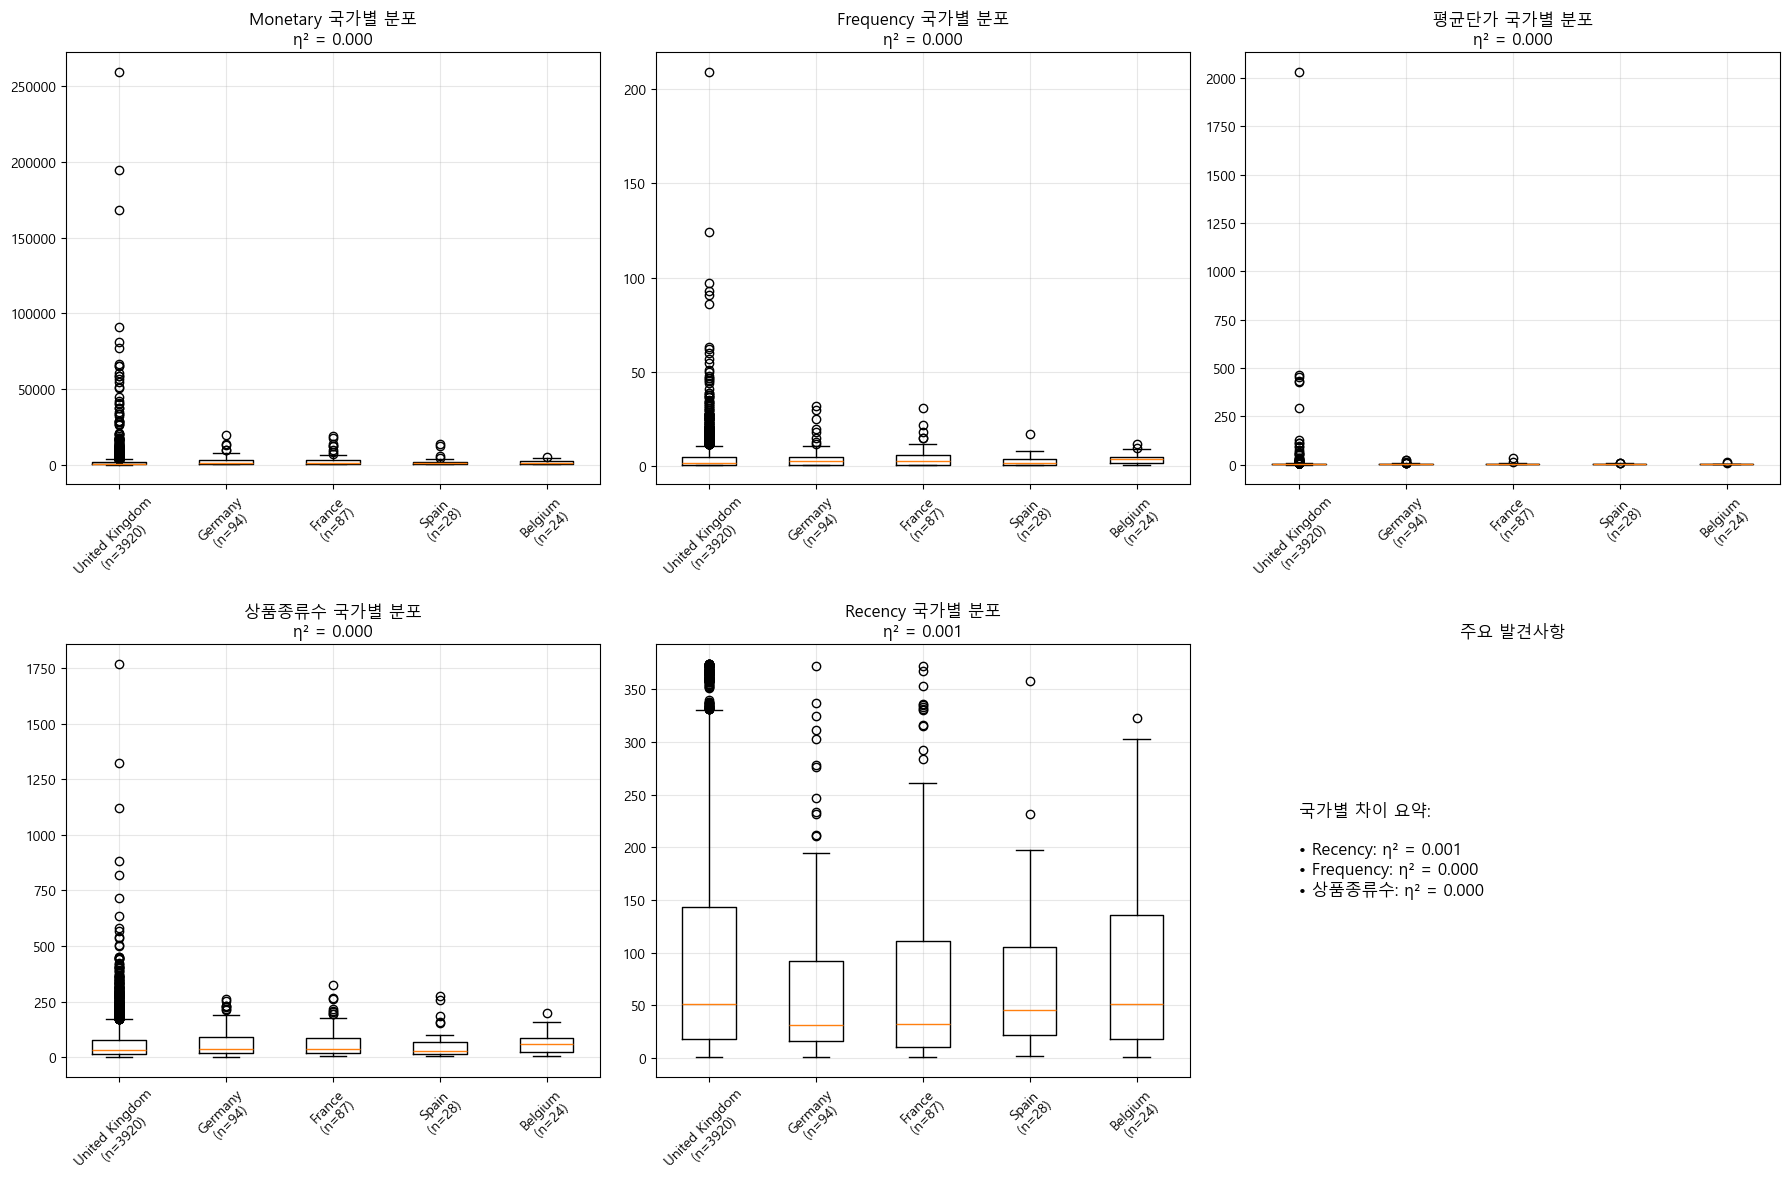


3. 국가별 구매 패턴 비즈니스 인사이트:
   Monetary:
     최고: Germany (2,435)
     최저: Belgium (1,731)
   평균단가:
     최고: United Kingdom (4)
     최저: Belgium (4)
   상품종류수:
     최고: Germany (68)
     최저: United Kingdom (61)


In [95]:
print("=== 혼합형 데이터 연관성 분석 ===")

# ----------------------------------------------------
# 1. 고객 데이터에 '국가' 정보 붙이기
# ----------------------------------------------------
# 고객별 첫 번째 국가값을 가져오기
customer_country = df_clean.groupby('CustomerID')['Country'].first()

# 기존 고객 통계 데이터(customer_stats)에 국가정보를 병합
customer_features_mixed = customer_stats.merge(customer_country, 
                                               left_index=True, right_index=True)

# 상위 5개 국가만 필터링 (표본 수 적은 국가는 분석에서 제외)
top_countries = customer_country.value_counts().head(5).index
customer_features_mixed = customer_features_mixed[
    customer_features_mixed['Country'].isin(top_countries)
]

# ----------------------------------------------------
# 2. 국가별 수치형 변수 차이 분석 (일원분산분석, ANOVA)
# ----------------------------------------------------
print("국가별 구매 특성 차이 분석 (일원분산분석):")

from scipy.stats import f_oneway

# 분석할 수치형 변수 목록
numeric_vars = ['Monetary', 'Frequency', '평균단가', '상품종류수', 'Recency']

anova_results = {}

for var in numeric_vars:
    # 국가별 데이터를 그룹 리스트로 생성
    groups = [customer_features_mixed[
                  customer_features_mixed['Country'] == country
              ][var] for country in top_countries]
    
    # ANOVA 검정 (국가별 평균 차이 있는지 확인)
    f_stat, p_value = f_oneway(*groups)
    anova_results[var] = {'f_stat': f_stat, 'p_value': p_value}
    
    # p-value 유의성 표시 (***: 매우 유의, **: 유의, *: 약간 유의)
    significance = "***" if p_value < 0.001 else \
                   "**" if p_value < 0.01 else \
                   "*" if p_value < 0.05 else ""
    
    print(f"   {var}: F = {f_stat:.3f}, p = {p_value:.4f} {significance}")

# ----------------------------------------------------
# 3. 범주형(국가) ↔ 수치형 변수 상관비(η²) 계산
# ----------------------------------------------------
print(f"\n 범주형-수치형 연관성 (상관비 η²):")

def correlation_ratio(categories, values):
    """
    상관비(η²) 계산
    - categories: 범주형 데이터 (예: 국가)
    - values: 수치형 데이터 (예: 평균단가)
    - η² 값이 0이면 연관성 없음, 1이면 완전한 연관성
    """
    # 범주형을 숫자로 변환
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1  # 범주 개수
    
    # 각 범주의 평균과 개수를 저장할 배열
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    
    for i in range(cat_num):
        cat_measures = values[fcat == i]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    
    # 전체 평균
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    
    # 분산 계산 (Between-group / Total)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg) ** 2)  # 그룹 간 분산
    denominator = np.sum((values - y_total_avg) ** 2)               # 전체 분산
    
    eta = 0 if denominator == 0 else np.sqrt(numerator / denominator)
    return eta ** 2  # η² 반환

# 국가와 수치형 변수 간 η² 계산
eta_squared_results = {}
for var in numeric_vars:
    eta_sq = correlation_ratio(customer_features_mixed['Country'], 
                                customer_features_mixed[var])
    eta_squared_results[var] = eta_sq
    print(f"   Country → {var}: η² = {eta_sq:.3f}")

# ----------------------------------------------------
# 4. 시각화 - 국가별 수치형 변수 분포 비교
# ----------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, var in enumerate(numeric_vars):
    if i < len(axes):
        data_for_plot = []
        labels_for_plot = []
        
        # 각 국가별 박스플롯 데이터 구성
        for country in top_countries:
            country_data = customer_features_mixed[
                customer_features_mixed['Country'] == country
            ][var]
            data_for_plot.append(country_data)
            labels_for_plot.append(f"{country}\n(n={len(country_data)})")
        
        axes[i].boxplot(data_for_plot, labels=labels_for_plot)
        axes[i].set_title(f'{var} 국가별 분포\nη² = {eta_squared_results[var]:.3f}')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

# 마지막 빈 그래프에 요약 텍스트 추가
if len(axes) > len(numeric_vars):
    axes[-1].axis('off')
    summary_text = "국가별 차이 요약:\n\n"
    
    # η² 값이 큰 순서대로 정렬
    sorted_eta = sorted(eta_squared_results.items(), key=lambda x: x[1], reverse=True)
    
    for var, eta_sq in sorted_eta[:3]:
        summary_text += f"• {var}: η² = {eta_sq:.3f}\n"
    
    axes[-1].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')
    axes[-1].set_title('주요 발견사항')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 5. 비즈니스 인사이트 출력
# ----------------------------------------------------
print(f"\n3. 국가별 구매 패턴 비즈니스 인사이트:")

# 국가별 평균값 계산
country_summary = customer_features_mixed.groupby('Country')[numeric_vars].mean().round(2)

# 주요 지표에서 최고/최저 국가 찾기
for var in ['Monetary', '평균단가', '상품종류수']:
    max_country = country_summary[var].idxmax()
    min_country = country_summary[var].idxmin()
    
    print(f"   {var}:")
    print(f"     최고: {max_country} ({country_summary.loc[max_country, var]:,.0f})")
    print(f"     최저: {min_country} ({country_summary.loc[min_country, var]:,.0f})")